# RC Temporal Subsampling
## NRMSE and NRMSE + KE RMSE Macro Cost

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

In [2]:
sys.path.append("..") 
from rcgfd import RCDataset, BigPlot, plot_ke_relerr, MetricsPlot

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

Penalizing normalized KE RMSE instead of total means that the small scales have less error at the cost of the larger 
scales, where as the total RMSE has slightly higher small scale error, but better representation of larger scales.

In [5]:
rcd = RCDataset(
    n_sub=[4, 16, 48],
    cost_terms = [
        {"nrmse": 1},
        {"nrmse": 1, "totspectral": 0.00001},
        {"nrmse": 1, "totspectral": 0.0001},
        # Any totspectral penalty higher than 10^-4 produces same results
        #{"nrmse": 1, "totspectral": 0.001},
        # this one is just shit
        #{"nrmse": 1, "global-integral": 0.0001},
    ]
)

In [6]:
%%time
ds = rcd()

CPU times: user 29.6 s, sys: 7.41 s, total: 37.1 s
Wall time: 35.3 s


In [7]:
ds["gamma"] = xr.DataArray([0., 1e-5, 1e-4], coords=ds.experiment.coords, dims=ds.experiment.dims)
ds = ds.swap_dims({"experiment":"gamma"})

Grab one sample for some plotting

In [9]:
xds = ds.sel(sample=49, n_sub=48, gamma=[0, 1e-5, 1e-4])

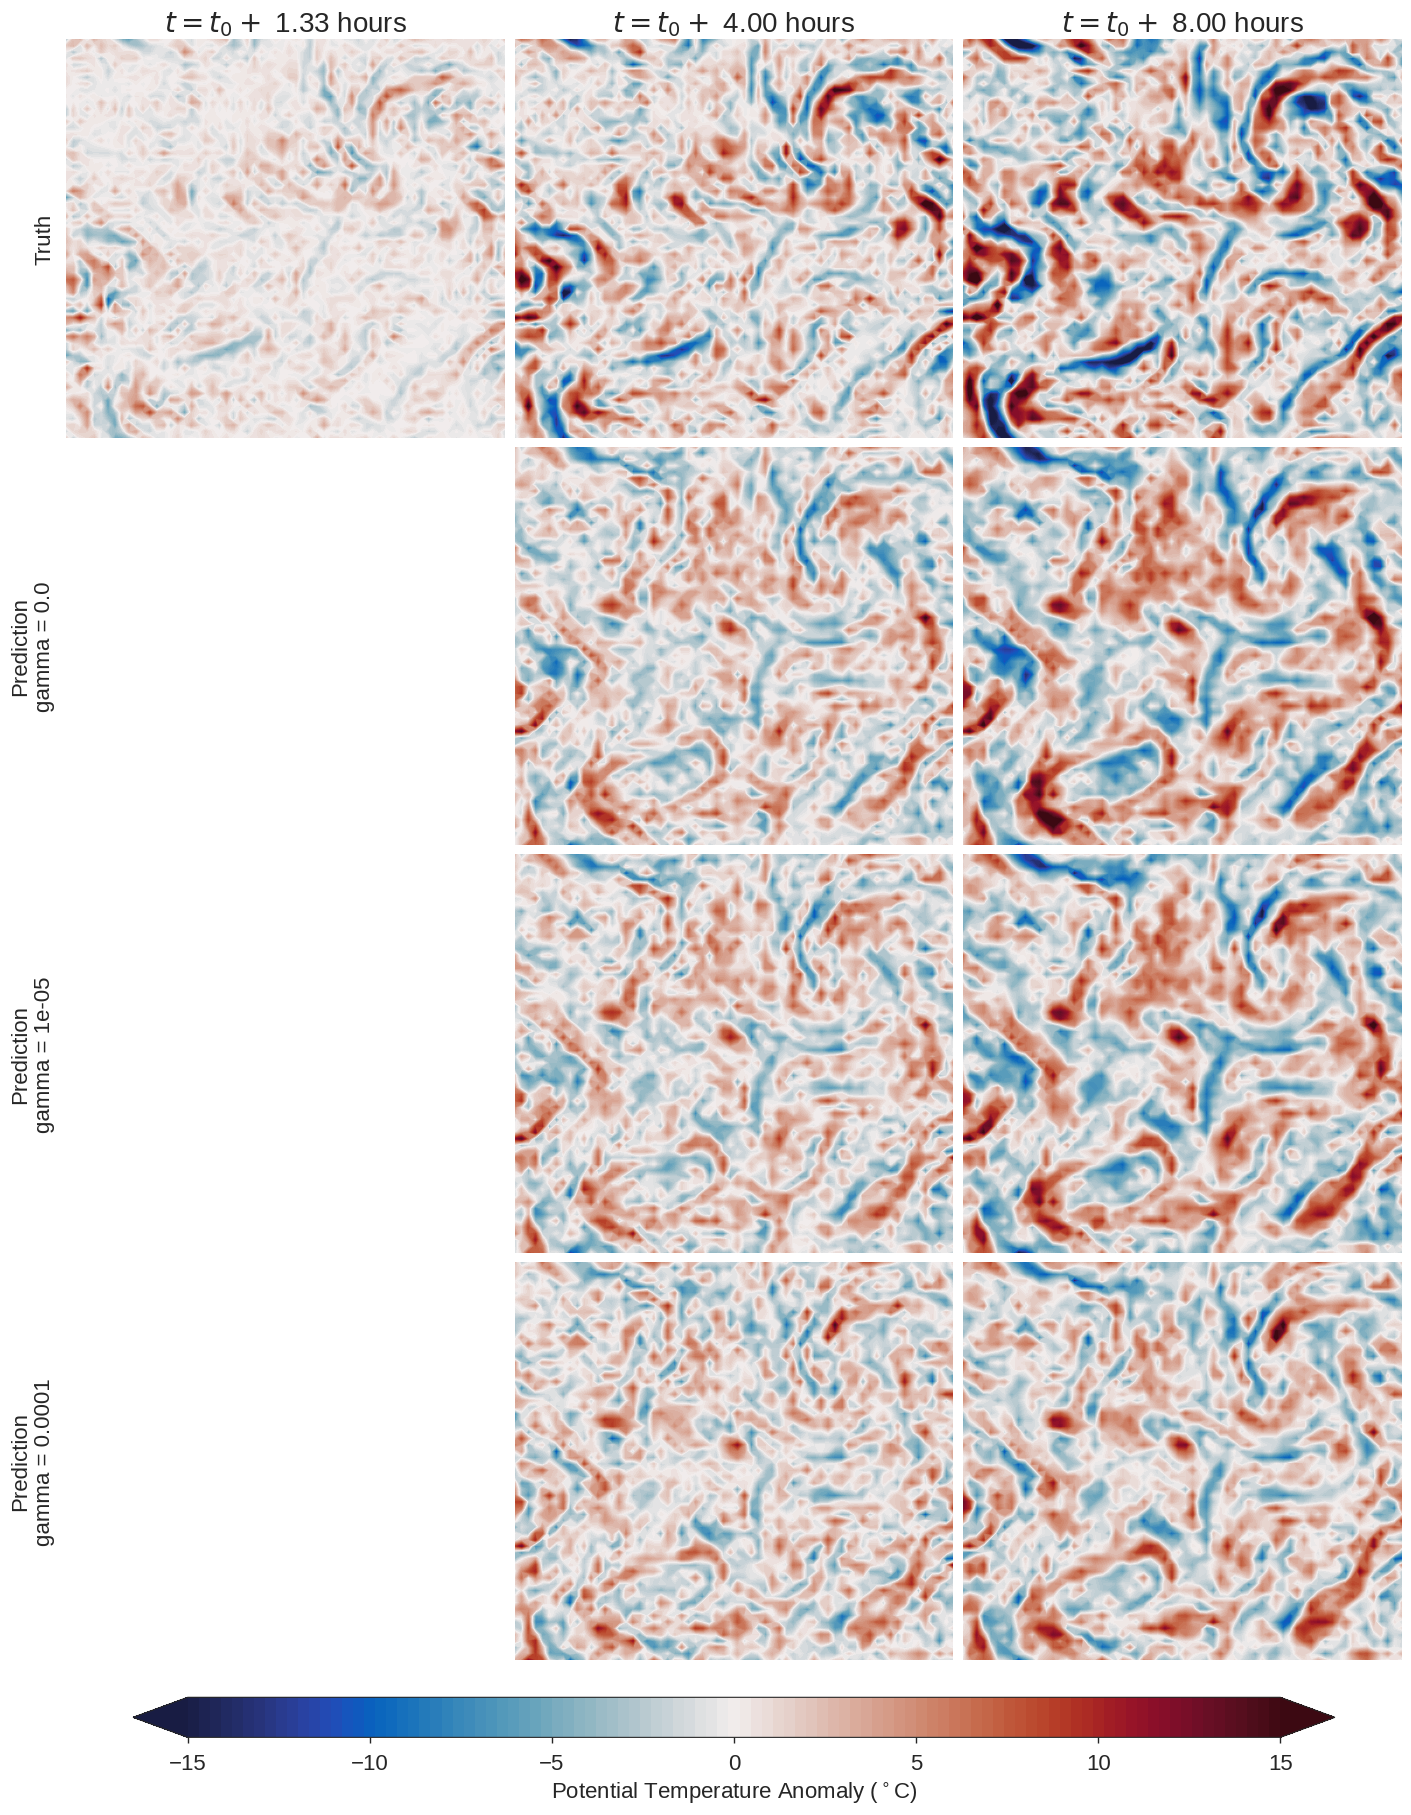

In [10]:
bp = BigPlot()
fig, axs = bp(xds, row_dim="gamma")

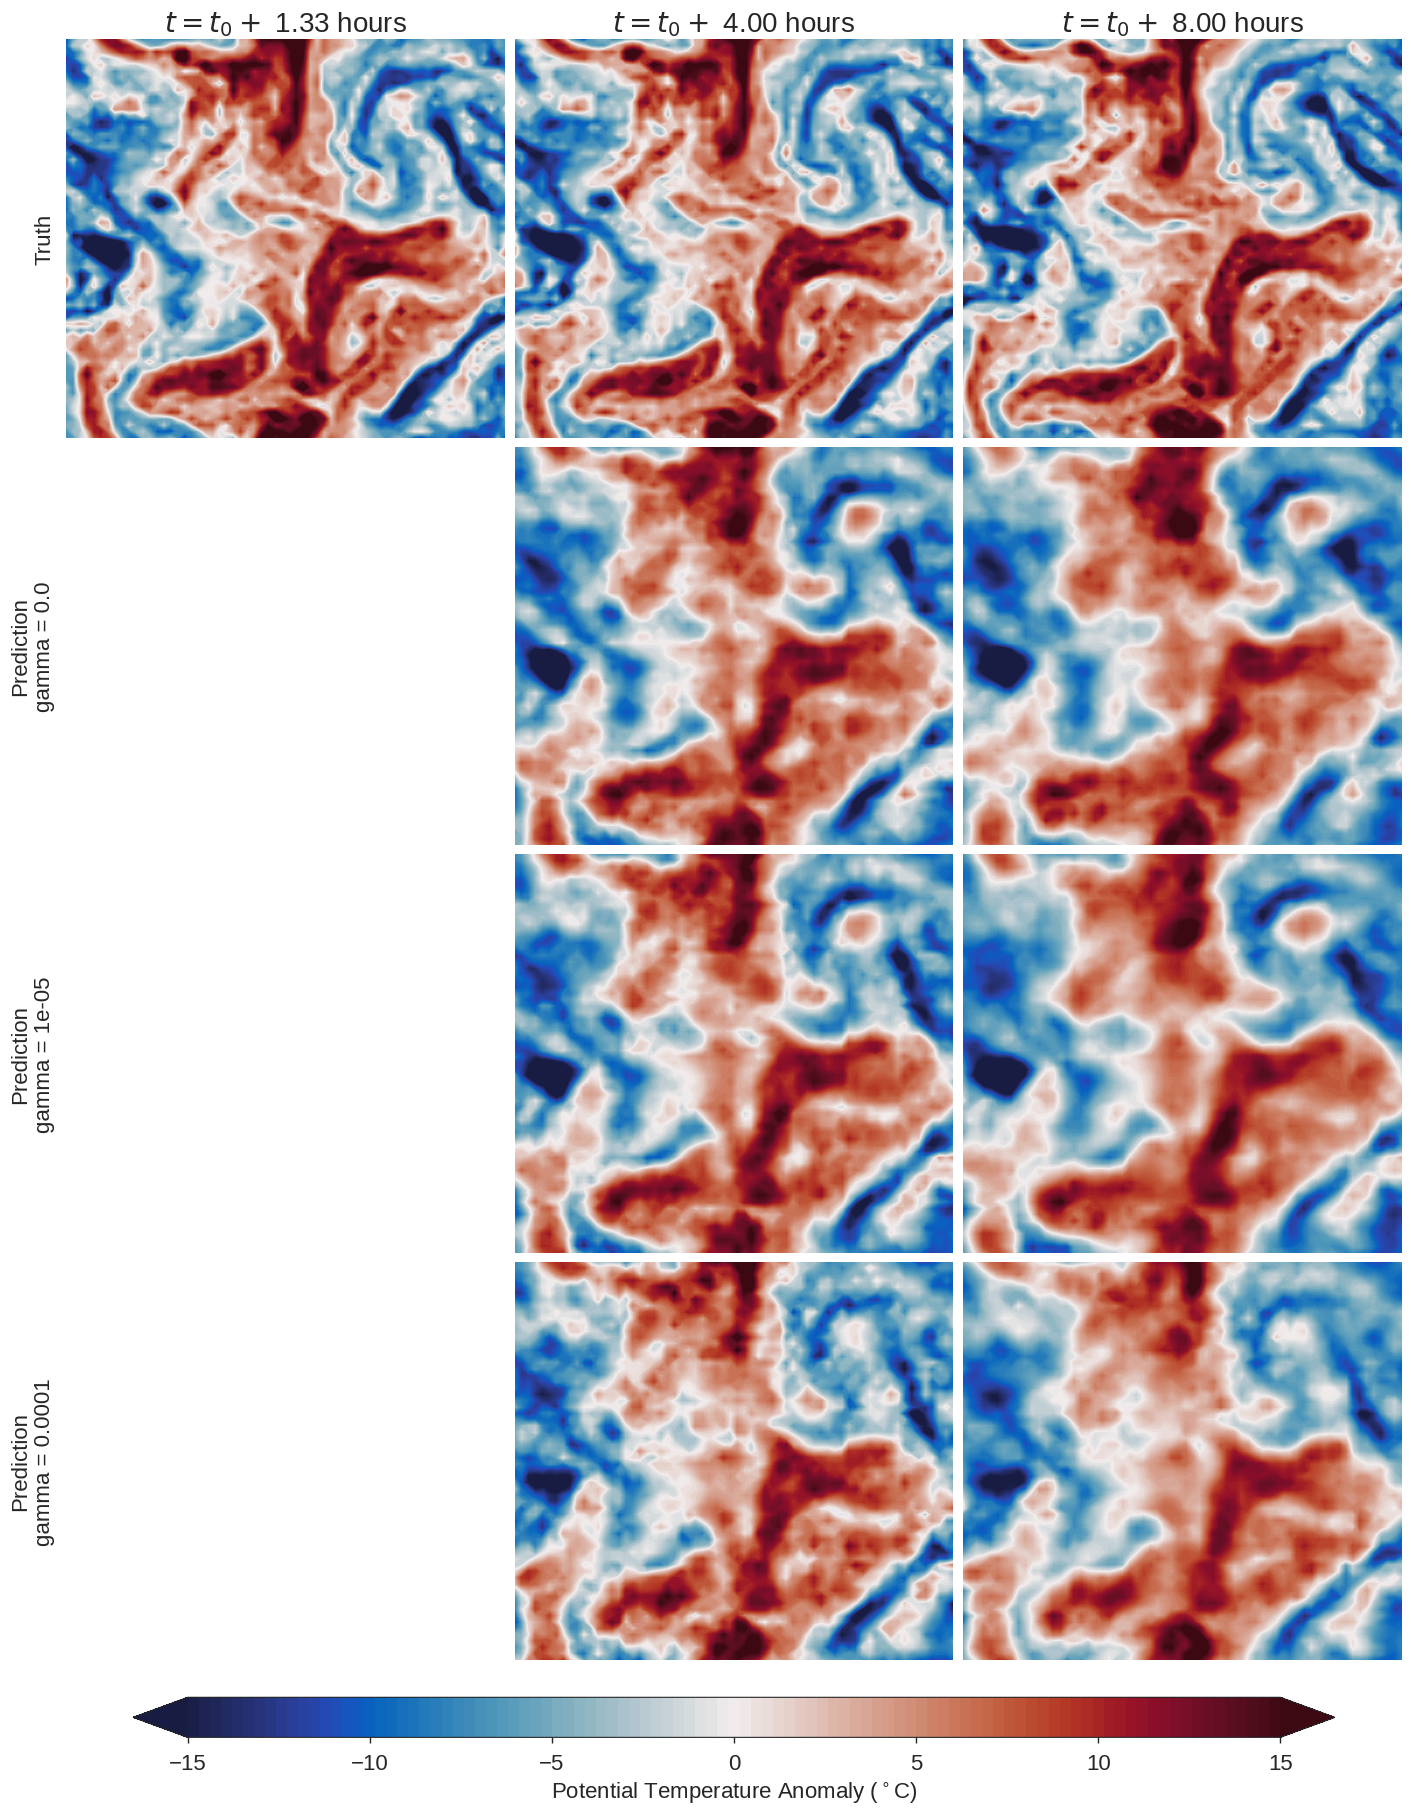

In [11]:
bp = BigPlot(diff_t0=False)
fig, axs = bp(xds, row_dim="gamma")

## Fix $N_{sub}$, compare different cost functions 

### A note on metrics

- The KE Density RMSE shows  pretty subtle differences between the runs
- KE Density NRMSE shows succinctly what we see in the Rel Err vs Wavenumber plots
- This is true whether we normalize the error by the true spectrum or its standard deviation
- The latter results in distributions that are easier to visualize, so go with that for now...

**It's interesting that we are optimizing based on RMSE, but see the impact in NRMSE**
Where the difference matters, because it basically controls how much we care about each wavenumber.
See more discussion in the relspec notebook.

In [12]:
ds['nrmse'].load();

In [13]:
ds["ke_relnrmse"] = np.sqrt( (ds["ke_rel_err"]**2).mean("k1d") )

In [14]:
mp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="gamma",
)

### $N_{sub}=48$

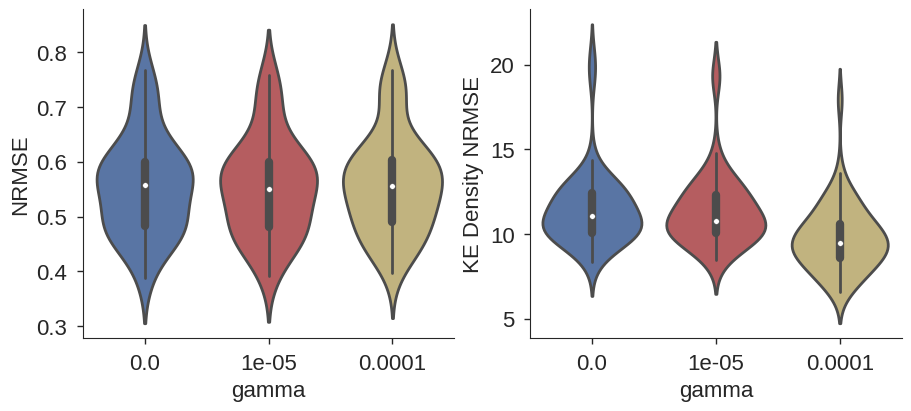

In [15]:
fig, axs = mp(ds.sel(n_sub=48), show_time=False)

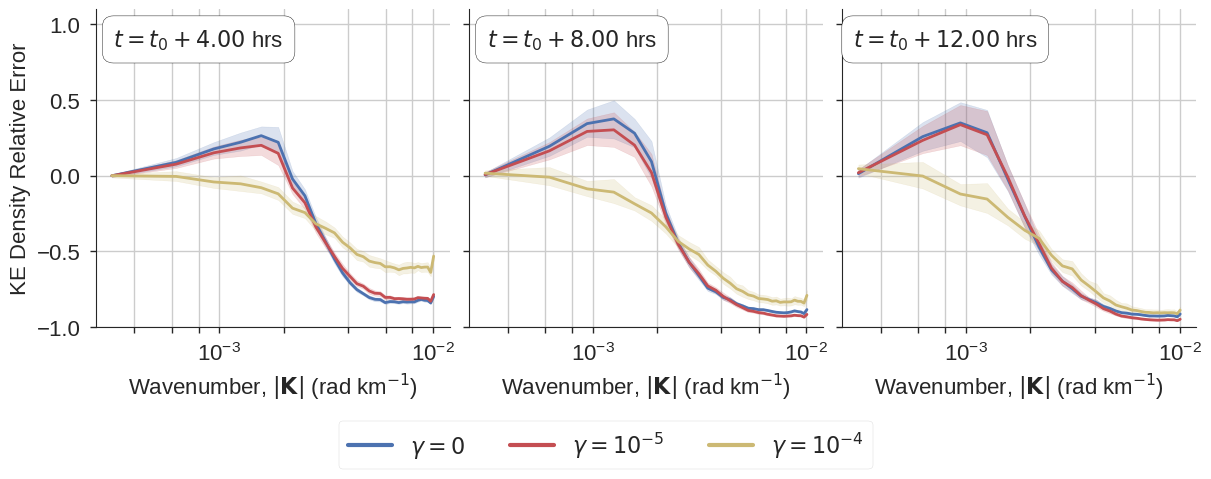

In [16]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=48),
    hours=(4, 8 , 12),
    cdim="gamma",
    clabel=mp.gamma_label)

### $N_{sub}$ = 16

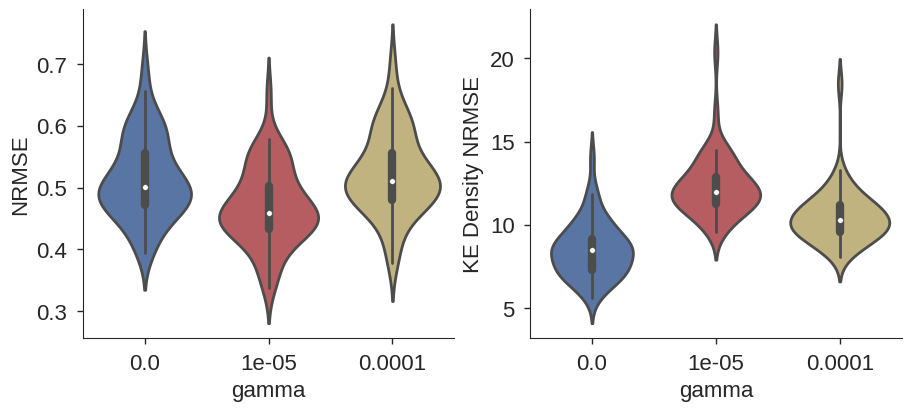

In [14]:
fig, axs = mp(ds.sel(n_sub=16), show_time=False)

In [15]:
#fig, axs = mp(ds.sel(n_sub=16), show_time=True)

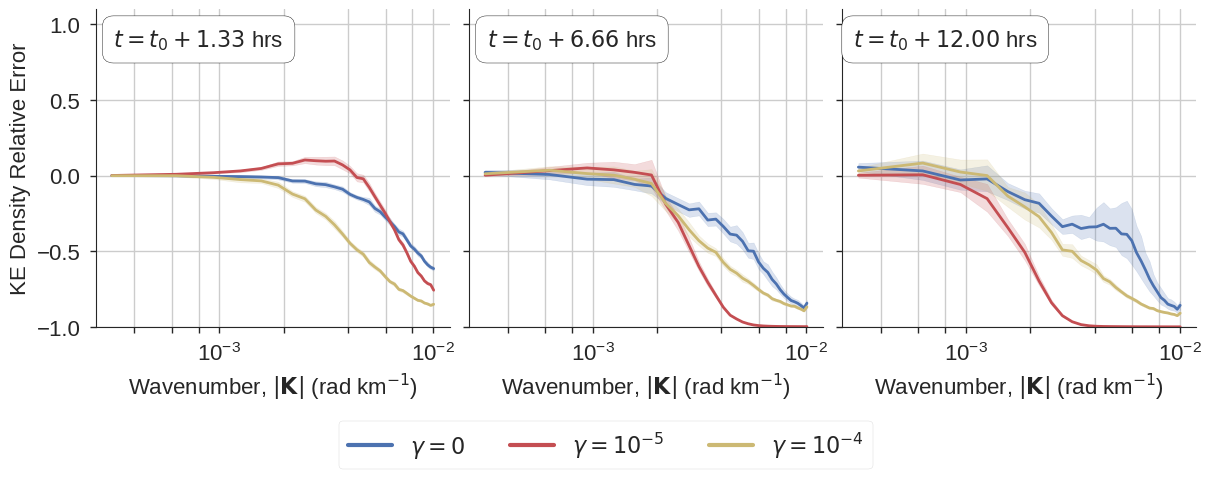

In [37]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=16),
    hours=(1.33, 6.66, 12),
    cdim="gamma",
    clabel=mp.gamma_label)

- Penalizing NRMSE alone actually seems the best, considering KE metrics, which is surprising because 
  we were trying to optimize for KE performance!
    - The median (and most of prob mass) Gamma=0 has lowest error in KE summary statistics
    - Relative error vs wavenumber shows Gamma=0 has least spectral bias
- On the other end, Gamma=1e-4 (and higher) is closest in KE metrics, and almost identical in terms of NRMSE.
    - The KE vs wavenumber is close to but "not as good" as Gamma = 0
    
- The balanced solution, Gamma=1e-5, has the most spectral bias, but best NRMSE. Probably not what we want!

**Why does penalizing spectrum make KE NRMSE slightly worse?**

Unreasonable expectations? If we can't resolve the full spectrum (or close to it?) then will it always fail?

### $N_{sub}$ = 4

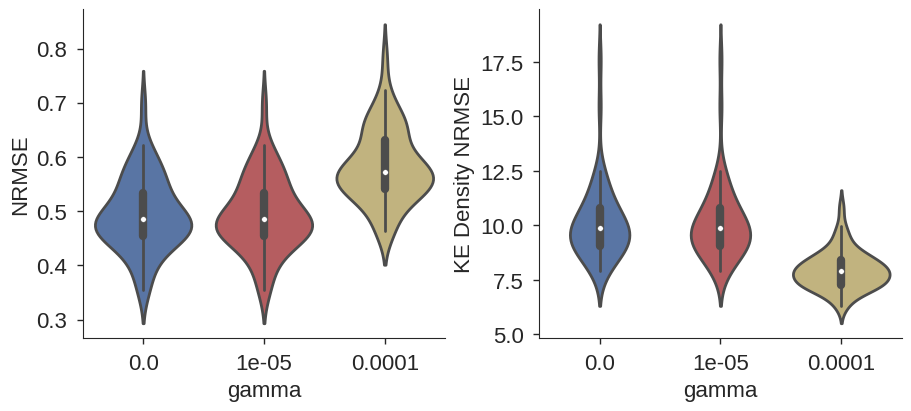

In [18]:
fig, axs = mp(ds.sel(n_sub=4), show_time=False)

[[(-1.0, 1.1)], [(-1.0, 1.1)], [(-1.0, 1.1)]]

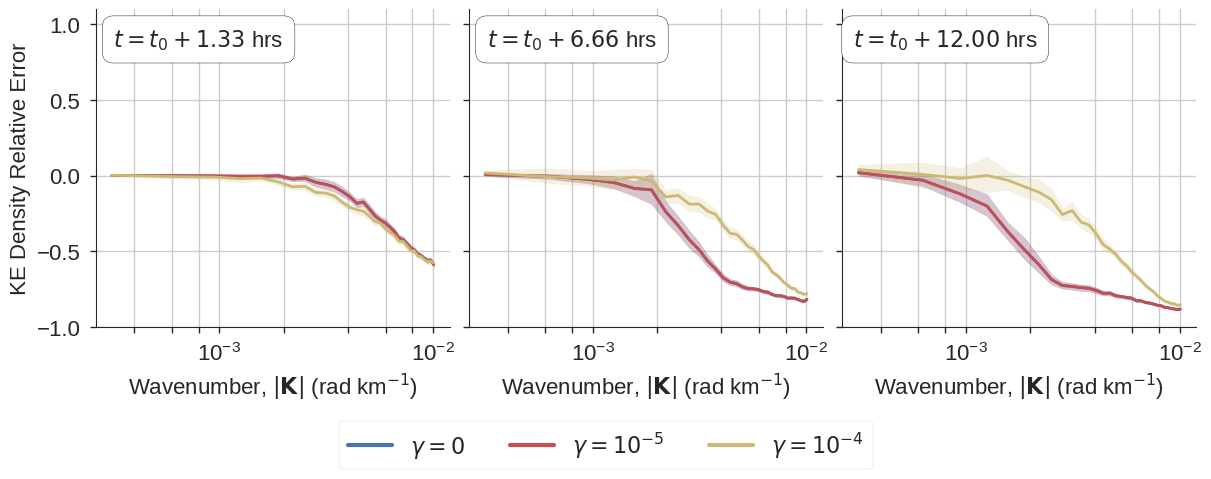

In [20]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=4),
    errorbar=("ci",99),
    cdim="gamma",
    hours=[1.33, 6.66, 12],
    clabel=mp.gamma_label)

[ax.set(ylim=[-1., 1.1]) for ax in axs]

- This $\gamma=0$ is equivalent to $\gamma\le10^{-5}$ and all sims with $\gamma\ge10^{-4}$ are the same
- This time, we do see a clear benefit to spectral penalty
- See a tradeoff: NRMSE (better with $\gamma=0$) vs spectral bias (better with $\gamma=10^{-4}$
- Interesting: the plots showing difference with t0 are much lower amplitude in $\gamma\ge10^{-4}$ case
  
**Why don't we see that error in the spectrum?**

**What happens if we use $\gamma = 5\cdot10^{-4}$?** Do we get the same issue as before where moderately penalizing 
results in a worse situation?

## Compare across Nsub with best spectral representation from each

In [21]:
nds = xr.concat([
    ds.sel(n_sub=4, gamma=1e-4).drop("gamma"),
    ds.sel(n_sub=16, gamma=0).drop("gamma"),
    ds.sel(n_sub=48, gamma=1e-4).drop("gamma"),
],dim="n_sub")

In [22]:
nsubp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="n_sub",
)

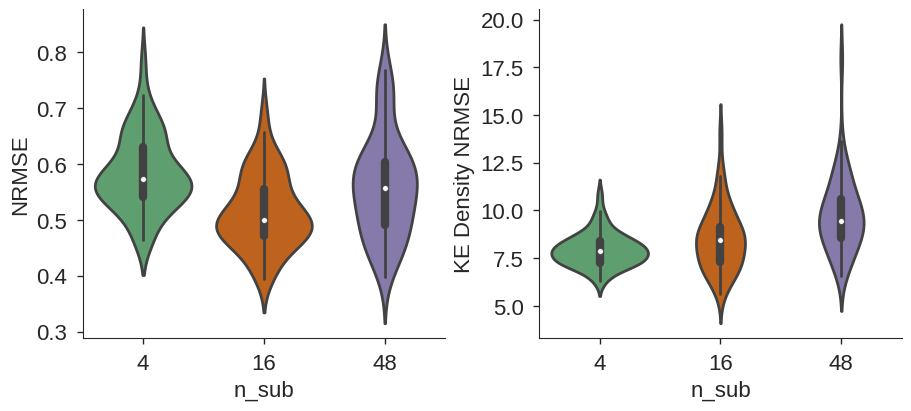

In [23]:
fig, axs = nsubp(nds, show_time=False)

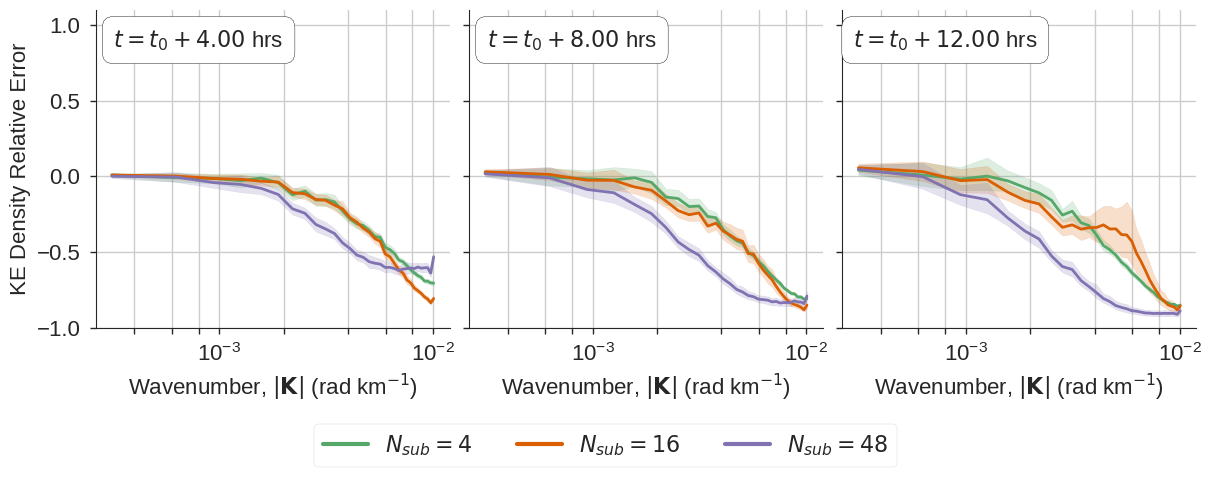

In [25]:
fig, axs = plot_ke_relerr(
    #ds["ke_rel_err"].sel(gamma=0),
    nds["ke_rel_err"],
    hours=(4, 8, 12),
    cdim="n_sub")

Whoa! Not much difference now between the different subsampling factors in terms of spectrum